In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys,time
import numpy as np
from scipy.constants import c,hbar
from scipy.interpolate import griddata

from chimera.moduls.species import Specie
from chimera.moduls.chimera_main import ChimeraRun
from chimera.moduls.SR import SR
from chimera.moduls import fimera as chimera

In [9]:
K0 = 0.1 
Periods=50
g0=100.0

StepsPerPeriod=40
gg = g0/(1.+K0**2/2)**.5
vb = (1.-gg**-2)**0.5
k_res = 2*gg**2
dt = 1./StepsPerPeriod
Steps2Do = int((Periods+2)/dt)+1

specie_in = {'TimeStep':dt,
             'Devices':([chimera.undul_analytic,np.array([K0, 1., 0, Periods])],)
            }

beam = Specie(specie_in)

NumParts = 1
beam.Data['coords'] = np.zeros((3,NumParts))
beam.Data['momenta'] = np.zeros((3,NumParts))

beam.Data['momenta'][0] = np.sqrt(g0**2-1)

beam.Data['coords_halfstep'] = beam.Data['coords'].copy()
beam.Data['weights'] = np.ones((NumParts,))/NumParts

chimera_in = {'Particles':(beam,),}
Chimera = ChimeraRun(chimera_in)

sr_in_near = {'Grid':[(0.02*k_res,1.1*k_res),(-15,15),(-15,15),1e3,(160,120,120)],
         'TimeStep':dt,'Features':(),'Mode':'near',
        }

sr_in_far = {'Grid':[(0.02*k_res,1.1*k_res),(0,2./g0),(0.,2*np.pi),(160,60,24)],
         'TimeStep':dt,'Features':(),
        }

sr_calc_far = SR(sr_in_far)
sr_calc_near = SR(sr_in_near)
sr_calc_far.init_track(Steps2Do,beam)
sr_calc_near.init_track(Steps2Do,beam)

In [10]:
t1 = time.time()
for i in range(Steps2Do):
    Chimera.make_step(i)
    sr_calc_far.add_track(beam)
    sr_calc_near.add_track(beam)
    
t2 = time.time()
print('Done orbits in {:g} sec'.format(t2-t1))

sr_calc_far.calculate_spectrum()
sr_calc_near.calculate_spectrum(comp='y')
print('Done spectrum in {:g} min'.format( (time.time()-t2)/60. ) )

Done orbits in 0.257451 sec
Done spectrum in 2.72401 min


In [11]:
FullSpect_far = sr_calc_far.get_full_spectrum(chim_units=False)
FullEnergy_far = sr_calc_far.get_energy(chim_units=False)/k_res

FullSpect_near = sr_calc_near.get_full_spectrum(chim_units=False)
ext_near = np.array(list(sum(sr_calc_near.Args['Grid'][1:3], ())))
FullEnergy_near = sr_calc_near.get_energy(chim_units=False)/k_res

print('** Full energies agree with {:.1f}% precision.'. \
      format(100*np.abs(FullEnergy_near/FullEnergy_far-1)))

** Full energies agree with 5.3% precision.


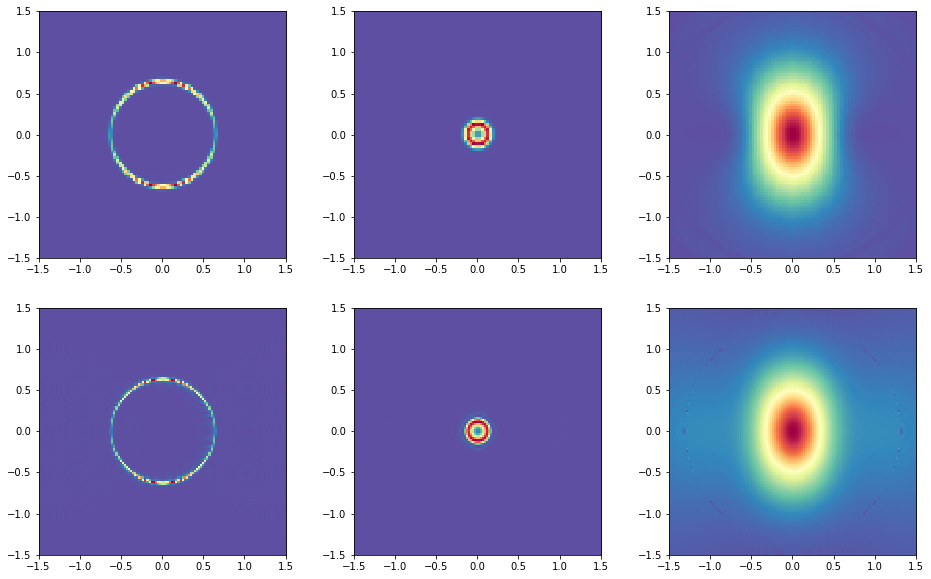

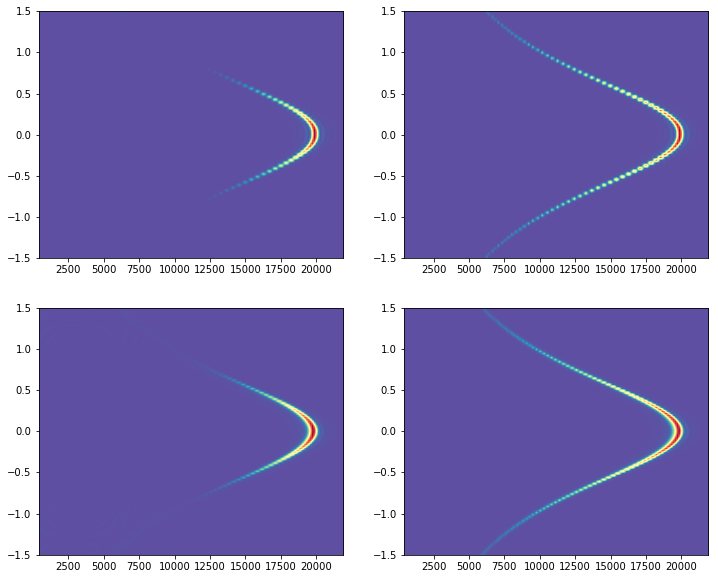

In [21]:
ext_wo_far = np.array(list(sum(sr_calc_far.Args['Grid'][0:2], ())))
ext_wo_far[2] = -ext_wo_far[3]
ext_wo_far[2:] *= g0

ext_wo_near = np.array(list(sum(sr_calc_near.Args['Grid'][0:2], ())))
ext_wo_near[2:] *= g0/(sr_calc_near.Args['Grid'][3])

fig,axs = plt.subplots(2,3, figsize=(16,10))
kk = 0.95*k_res
for i in range(3):
    kk = (0.7*k_res, 0.98*k_res, None)[i]
    (ax1,ax2) = axs[:,i]
    spotXY_far,ext_far = sr_calc_far.get_spot_cartesian(chim_units=False,k0=kk,bins=(120,120))
    spotXY_near = sr_calc_near.get_spot(chim_units=False,k0=kk)
    ax1.imshow(spotXY_far.T,origin='lower', cmap = plt.cm.Spectral_r,
               extent=g0*ext_far)
    ax2.imshow(spotXY_near.T, origin='lower',cmap=plt.cm.Spectral_r,
               extent=g0*ext_near/(sr_calc_near.Args['Grid'][3]) )
    for ax in (ax1,ax2):
        ax.set_xlim(-1.5,1.5)
        ax.set_ylim(-1.5,1.5)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,10))

ax1.imshow(np.hstack((FullSpect_far[:,::-1,0],FullSpect_far[:,:,12])).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_far)

ax2.imshow(np.hstack((FullSpect_far[:,::-1,6],FullSpect_far[:,:,18])).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_far)
        
ax3.imshow(FullSpect_near[:,:,55:66].mean(-1).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_near )

ax4.imshow(FullSpect_near[:,58:66,:].mean(-2).T,
           origin='lower',interpolation='bilinear',
           aspect='auto',cmap=plt.cm.Spectral_r,
           extent=ext_wo_near )

for ax in (ax1,ax2,ax3,ax4):
    ax.set_ylim(-1.5,1.5)